<a href="https://colab.research.google.com/github/RMCV-Rajapaksha/TeamInception_Datathon/blob/malitha/Copy_of_task2_eda_and_data_preprocessing_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 Notebook for "XGBoost"


## Imports and Setup

**Import the Libararies**


In [47]:
# !pip install tensorflow pandas numpy matplotlib scikit-learn

In [48]:
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

### Connecting to Google Drive

In [49]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading data set files

In [50]:
# Developers please update the paths according to were in your google you place datasets
# i recommend making Rootcode-ML folder and in it Datasets folder and placing the csv files there then you wont have to change below code block
df_bookings = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/bookings_train.csv')
df_tasks = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/tasks.csv')
df_staffing = pd.read_csv('/content/drive/MyDrive/Rootcode-ML/Datasets/staffing_train.csv')

# Data Preprocessing


--- Outlier Analysis ---


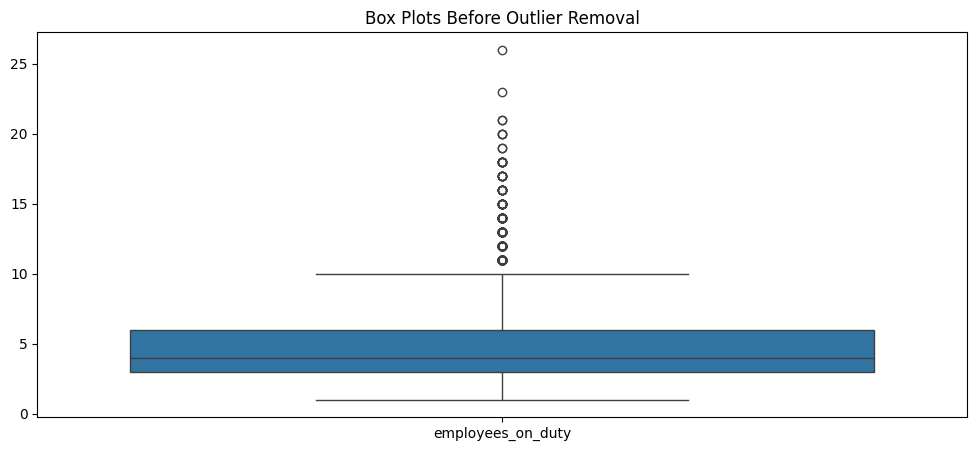

Removed 223 rows from staffing data due to outliers.


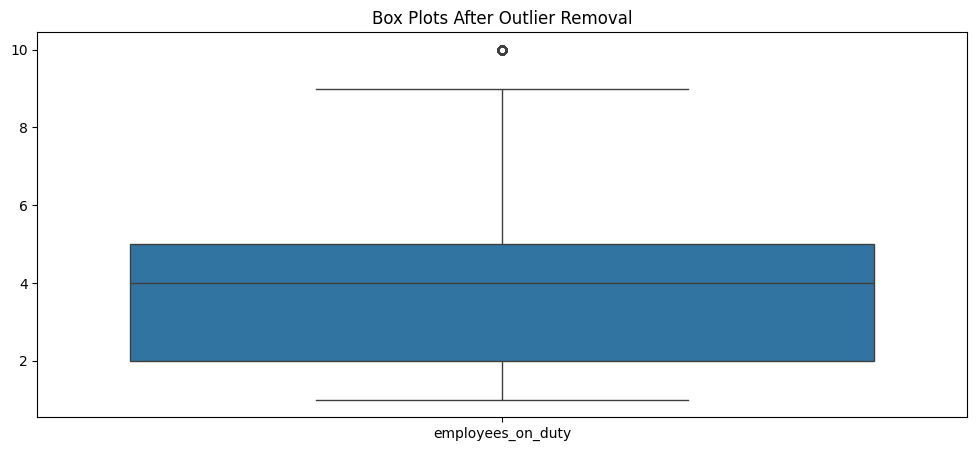

In [51]:
# --- 3.1 Preprocess Bookings Data ---
df_bookings.dropna(subset=['check_in_time', 'check_out_time'], inplace=True)
df_bookings['satisfaction_rating'].fillna(0, inplace=True)
df_bookings['booking_date'] = pd.to_datetime(df_bookings['booking_date'])
df_bookings['appointment_date'] = pd.to_datetime(df_bookings['appointment_date'])
df_bookings['check_in_time'] = pd.to_datetime(df_bookings['check_in_time'])
df_bookings['check_out_time'] = pd.to_datetime(df_bookings['check_out_time'])

# --- 3.2 Preprocess Staffing Data ---
df_staffing['date'] = pd.to_datetime(df_staffing['date'])
df_staffing['employees_on_duty'].fillna(0, inplace=True)

# --- 3.3 Outlier Detection and Removal ---
print("\n--- Outlier Analysis ---")
outlier_columns = ['employees_on_duty']
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_staffing[outlier_columns])
plt.title('Box Plots Before Outlier Removal')
plt.show()

initial_staffing_rows = len(df_staffing)
for col in outlier_columns:
    Q1 = df_staffing[col].quantile(0.25)
    Q3 = df_staffing[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_staffing = df_staffing[(df_staffing[col] >= lower_bound) & (df_staffing[col] <= upper_bound)]

print(f"Removed {initial_staffing_rows - len(df_staffing)} rows from staffing data due to outliers.")
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_staffing[outlier_columns])
plt.title('Box Plots After Outlier Removal')
plt.show()


# EDA


Staffing Data Summary:

Bookings Data Summary (numerical columns):


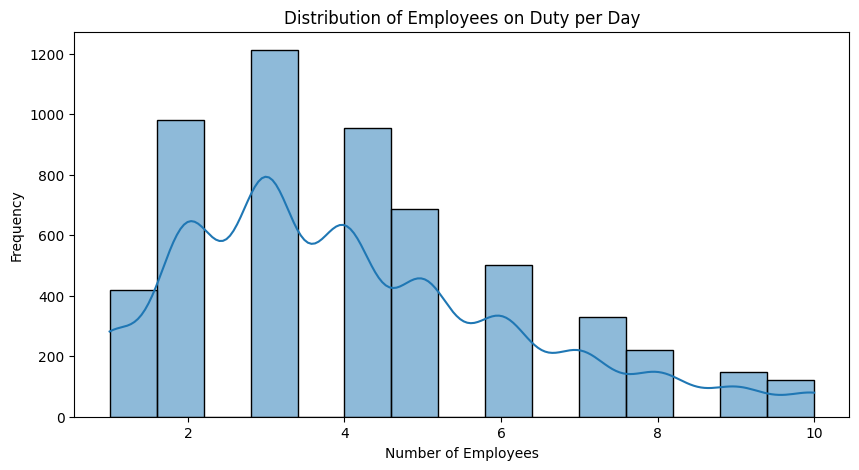

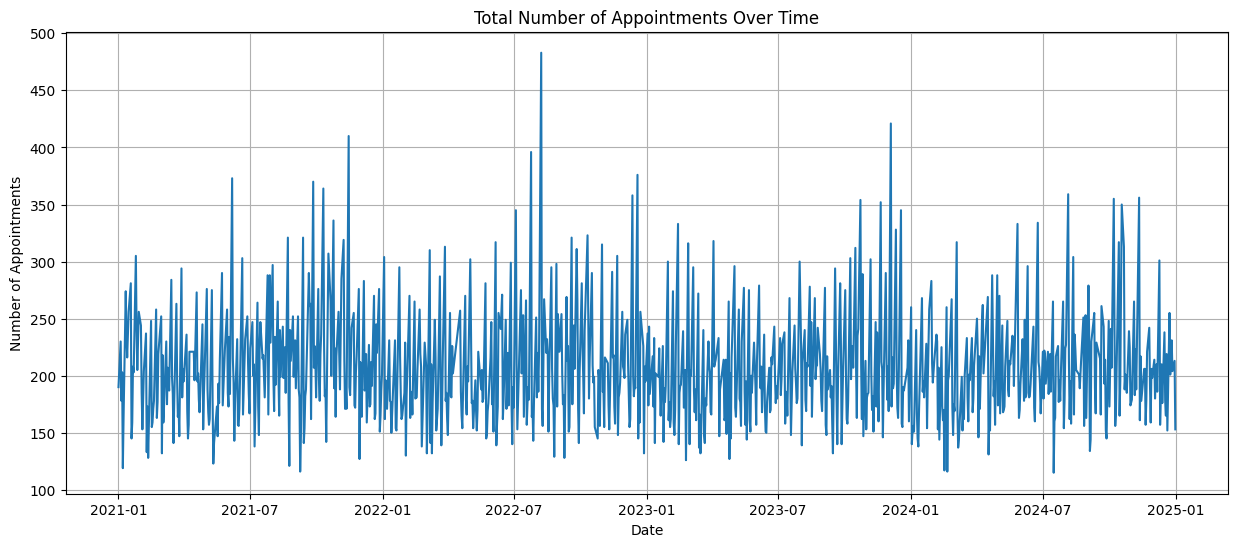

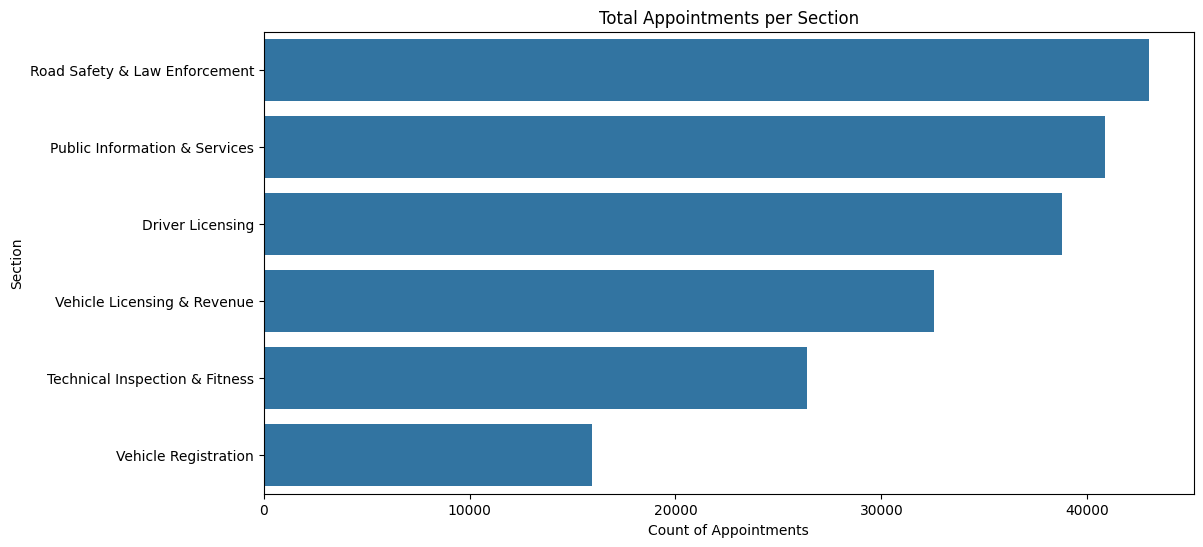

In [52]:
# --- 1. Descriptive Statistics ---
# Get a summary of the numerical columns in your main datasets.
print("\nStaffing Data Summary:")
df_staffing.describe()

print("\nBookings Data Summary (numerical columns):")
df_bookings[['num_documents', 'satisfaction_rating']].describe()


# --- 2. Distribution of Key Variables ---
# Use histograms to see the distribution of employees on duty.
plt.figure(figsize=(10, 5))
sns.histplot(df_staffing['employees_on_duty'], bins=15, kde=True)
plt.title('Distribution of Employees on Duty per Day')
plt.xlabel('Number of Employees')
plt.ylabel('Frequency')
plt.show()


# --- 3. Time Series Analysis: Appointments Over Time ---
# This helps to visualize trends and seasonality.
# We'll group by appointment date to see the daily volume.
daily_appointments = df_bookings.groupby(df_bookings['appointment_date'].dt.date).size()

plt.figure(figsize=(15, 6))
daily_appointments.plot()
plt.title('Total Number of Appointments Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Appointments')
plt.grid(True)
plt.show()


# --- 4. Appointments by Section ---
# Use a bar chart to see which sections are the busiest.
# First, we need to merge bookings with tasks to get section names.
df_bookings_with_sections = pd.merge(df_bookings, df_tasks, on='task_id', how='left')

plt.figure(figsize=(12, 6))
sns.countplot(y='section_name', data=df_bookings_with_sections, order=df_bookings_with_sections['section_name'].value_counts().index)
plt.title('Total Appointments per Section')
plt.xlabel('Count of Appointments')
plt.ylabel('Section')
plt.show()


# Merging and Feature Engineering

In [53]:
# --- 4.1 Merge Datasets ---
df_bookings_merged = pd.merge(df_bookings, df_tasks, on='task_id', how='left')
df_bookings_merged['appointment_date'] = pd.to_datetime(df_bookings_merged['appointment_date'])
df_workload = df_bookings_merged.groupby(
    [df_bookings_merged['appointment_date'].dt.date, 'section_id']
).agg(
    total_appointments=('booking_id', 'count'),
    total_documents=('num_documents', 'sum')
).reset_index()
df_workload = df_workload.rename(columns={'appointment_date': 'date'})

df_staffing['date'] = pd.to_datetime(df_staffing['date'])
df_workload['date'] = pd.to_datetime(df_workload['date'])
training_df = pd.merge(df_staffing, df_workload, on=['date', 'section_id'], how='left')
training_df['total_appointments'].fillna(0, inplace=True)
training_df['total_documents'].fillna(0, inplace=True)

# --- 4.2 Feature Engineering ---
def create_time_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int)
    return df

training_df = create_time_features(training_df)
if 'section_id' in training_df.columns:
    training_df = pd.get_dummies(training_df, columns=['section_id'], prefix='section', dtype=int)


# Modal Training and Tunning

In [54]:
# --- 5.1 Define Features, Target, and Split Data ---
y = training_df['employees_on_duty']
X = training_df.drop(columns=['employees_on_duty', 'date'])

# IMPORTANT: Adjust this split_date based on your data's range.
split_date = '2024-03-01'
train_indices = training_df['date'] < split_date
val_indices = training_df['date'] >= split_date
X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# --- 5.2 Hyperparameter Tuning with GridSearchCV ---
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 4],
}
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2
)
print("⏳ Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)
print(f"✅ Tuning complete! Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_



Training data shape: (4410, 17)
Validation data shape: (1169, 17)
⏳ Starting hyperparameter tuning...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.3s
[CV] END .learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END .learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END .learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=500; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=500; total time=   2.0s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=500; total time=   1.6s
[CV] END .learning_rate=0.01, max_depth=4, n_estimators=1000; total time=   0.7s
[CV] END .learning_rate=0.01

# Model Evaluation

Tuned Model Performance on Validation Data:
Mean Absolute Error (MAE): 0.42
R-squared (R²): 0.91


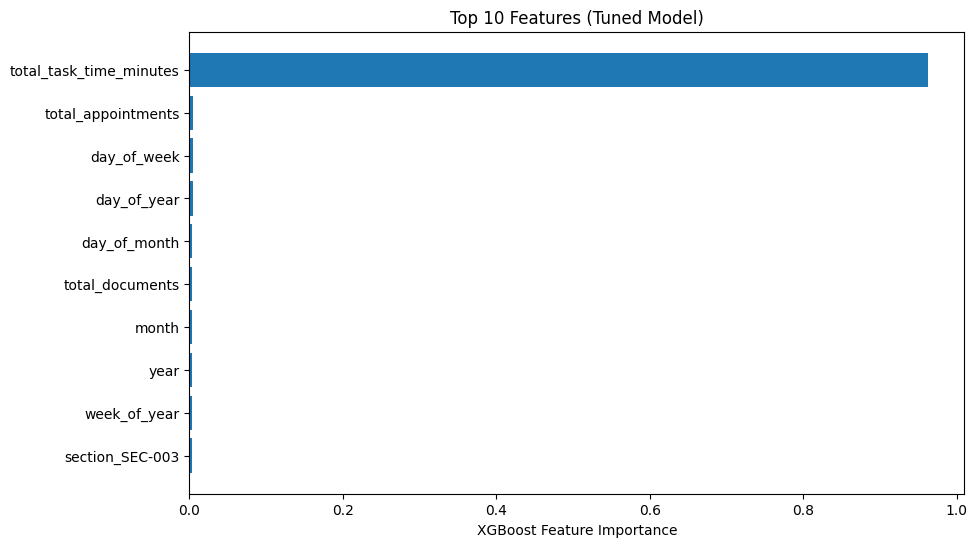

In [55]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# --- Make predictions using the BEST model from the search ---
y_pred_tuned = best_model.predict(X_val)
mae_tuned = mean_absolute_error(y_val, y_pred_tuned)
rmse_tuned = root_mean_squared_error(y_val, y_pred_tuned)
r2_tuned = r2_score(y_val, y_pred_tuned)

print(f"Tuned Model Performance on Validation Data:")
print(f"Mean Absolute Error (MAE): {mae_tuned:.2f}")
print(f"R-squared (R²): {r2_tuned:.2f}")

# --- Feature Importance from the Tuned Model ---
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'][:10], feature_importances['importance'][:10])
plt.xlabel('XGBoost Feature Importance')
plt.title('Top 10 Features (Tuned Model)')
plt.gca().invert_yaxis()
plt.show()



In [56]:
# --- Compare R² scores to check for overfitting ---

# Make predictions on the training data
y_pred_train = best_model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)

# Make predictions on the validation (testing) data
y_pred_val = best_model.predict(X_val)
r2_val = r2_score(y_val, y_pred_val)

print(f"Training R-squared (R²): {r2_train:.2f}")
print(f"Validation/Testing R-squared (R²): {r2_val:.2f}")

Training R-squared (R²): 0.92
Validation/Testing R-squared (R²): 0.91
